## Imports

In [9]:
from bs4 import BeautifulSoup
import urllib
import re
import asyncio
import aiohttp
import networkx as nx
from collections import deque
import matplotlib.pyplot as plt
import time
import pickle
from itertools import combinations
from math import inf
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import numpy as np
from PIL import Image
import logging

## Code to use

It is the same as in .py files, but I have to copy-past it because "import from " raise errors

In [10]:
async def get_actors_by_movie_soup(cast_page_soup: BeautifulSoup, num_of_actors_limit: int = None) -> list:
    """
    Getting tuples of actors and their IMDB pages and return complete list

    :parameter cast_page_soup: a soup of all cast members of a movie: BeautifulSoup
    :argument num_of_actors_limit: optional limit on how many actors to grab from a movie: int or None
    :return: cast_list (limited or complete cast members list): dictionary
    """
    # Get the table of cast
    cast = cast_page_soup.select('table.cast_list td.primary_photo a', limit=num_of_actors_limit)
    cast_list = []
    # Check if there is a limit on actors
    for actor in range(len(cast)):
        name = cast[actor].find('img')['title']
        logging.info(f"Found actor: {name}")
        actor_url = await helper_imdb_rellink(cast[actor]['href'])
        cast_list.append((name, actor_url))
    logging.info(f"Found {len(cast_list)} actors in the movie")
    return cast_list


async def get_movies_by_actor_soup(actor_page_soup: BeautifulSoup, num_of_movies_limit: int = None) -> list:
    """
    Getting the list of movies for actor with filtering to exclude non-movies and unreleased movies

    :argument actor_page_soup: BeautifulSoup
    :parameter num_of_movies_limit: optional limit on how many movies to grab for an actor: int or None
    :return: movie_list (complete or limited movies excluding tv shows and other media for given actor): list
    """
    # Find all movies where actor participated as actor
    soup = actor_page_soup.find_all('div', {'id': re.compile('act(or|ress)-[\w]+')})

    counter = 0
    movie_list = []
    # Iterate through each movie
    for title in soup:
        links = title.select('a')
        # See if previous to br element contains something like (Video Game)
        try:
            type_of_title = len(title.find('br').previous_element)
        except AttributeError:
            type_of_title = 0
        # Movies with additional status have more than one link
        if len(links) == 1 and type_of_title < 3:
            txt = links[0].get_text()
            url = await helper_imdb_rellink(links[0]['href'])
            logging.info(f"Found movie: {txt}, url: {url}")
            movie_list.append((txt, url))
            #             movie_list[txt] = url
            counter += 1
        # Check if there is a limit on number of films and abide by it
        if num_of_movies_limit and counter == num_of_movies_limit:
            logging.info(f"Limit of {num_of_movies_limit} reached!")
            break
    logging.info(f"Found {len(movie_list)} movies")
    return movie_list


async def get_movie_distance(actor_start_url: str, actor_end_url: str,
                             num_of_actors_limit: int = None,
                             num_of_movies_limit: int = None,
                             depth_limit: int = None,
                             chunk_size: int = 10) -> int or float:
    """
    Calculating the hops between actors

    :argument depth_limit: limits how deep this rabbit hole goes: int
    :parameter actor_start_url: url of actor to begin calculation: str
    :parameter actor_end_url: url of actor algorithm must traverse to: str
    :argument num_of_actors_limit: optional limit on how many actors to grab from a movie: int or None
    :argument num_of_movies_limit: optional limit on how many movies to grab for an actor: int or None
    :argument chunk_size: limit on semaphore and defines chunks for which async grab happens: int
    :return: number of hops between actors: int
    """
    actor_start_url = actor_start_url.replace('www.', '')
    actor_end_url = actor_end_url.replace('www.', '')
    forward_actors = deque()
    backward_actors = deque()
    seen_actors = set()
    seen_movies = set()
    forward_actors.append([actor_start_url])
    backward_actors.append([actor_end_url])
    distance = 0
    sem = asyncio.Semaphore(chunk_size)
    # To not overheat IMDB servers
    if not depth_limit:
        depth_limit = 3
        logging.info(f"Searching for distance between {actor_start_url} and {actor_end_url}\
                        with distance limit {depth_limit}")
    # Do bi-directional BFS traversal until either target has been found or there is intersection in the next level
    async with aiohttp.ClientSession(raise_for_status=True) as session:
        try:
            while distance < depth_limit:
                try:
                    forward_urls = forward_actors.popleft()
                    backward_urls = backward_actors.popleft()
                except IndexError as e:
                    logging.exception(f"Deque is exhausted, no actors left to check on level {distance}")
                    raise Exception("Deque is exhausted, no actors left to check")
                # Get next level forward
                found_f, next_level_f, f_act, f_mov = await bfs(session, sem, chunk_size,
                                                                forward_urls, seen_actors, seen_movies,
                                                                num_of_actors_limit, num_of_movies_limit, actor_end_url)
                logging.info("Forward BFS successful")
                if found_f:
                    logging.info("Found in BFS forward")
                    return distance + 1
                # Checking if next level forward will include someone we would otherwise check in current level back
                if len(set(next_level_f).intersection(set(backward_urls))) > 0:
                    logging.info("Caught when checking next level of BFS-forward against current level of BFS-back")
                    distance = (2 * distance) + 1
                    return distance
                # Get next level backward
                found_b, next_level_b, b_act, b_mov = await bfs(session, sem, chunk_size,
                                                                backward_urls, seen_actors, seen_movies,
                                                                num_of_actors_limit, num_of_movies_limit,
                                                                actor_start_url)
                logging.info("Backwards BFS successful")
                if found_b:
                    logging.info("Found in BFS backward")
                    return distance + 1
                # Checking in next level backward contains someone we already checked
                if len(set(next_level_b).intersection(set(forward_urls))) > 0:
                    logging.info("Caught when checking next level of BFS-back against current level of BFS-forward")
                    distance = (2 * distance) + 1
                    return distance
                # Finally, checking if next levels will intersect so we don't have to actually grab them
                if len(set(next_level_f).intersection(set(next_level_b))) > 0:
                    logging.info("Caught when checking both next level")
                    distance = (2 * distance) + 2
                    return distance
                # If no matches were found, we advance to the next level and up the distance
                logging.info(f"No matches found on this level, next to check f: {len(next_level_f)}, b: {len(next_level_b)}")
                forward_actors.append(next_level_f)
                backward_actors.append(next_level_b)
                # Updating seen lists
                seen_actors.update(f_act)
                seen_movies.update(f_mov)
                seen_actors.update(b_act)
                seen_movies.update(b_mov)
                distance += 1
        except aiohttp.ClientResponseError as e:
            logging.exception("IMDB returned non-200 status: you might have been banned.")
            raise Exception('You may have been banned').with_traceback(e.__traceback__)
    return inf

async def get_movie_descriptions_by_actor_soup(actor_page_soup: BeautifulSoup, chunk_size: int = 10) -> str:
    """
    Getting the list of movies for actor with filtering to exclude non-movies and unreleased movies

    :param chunk_size: defines the characteristics of Semaphore
    :argument actor_page_soup: BeautifulSoup
    :return: movie_list (complete or limited movies excluding tv shows and other media for given actor): list
    """
    # Find all movies where actor participated as actor
    soup = actor_page_soup.find_all('div', {'id': re.compile('act(or|ress)-[\w]+')})
    movie_list = []
    # Iterate through each movie
    for title in soup:
        links = title.select('a')
        # See if previous to br element contains something like (Video Game)
        try:
            type_of_title = len(title.find('br').previous_element)
        except AttributeError:
            type_of_title = 0
        # Movies with additional status have more than one link
        if len(links) == 1 and type_of_title < 3:
            url = urllib.parse.urljoin('https://imdb.com', links[0]['href'])
            movie_list.append(url)
    sem = asyncio.Semaphore(chunk_size)
    async with aiohttp.ClientSession(raise_for_status=True) as session:
        try:
            movies_soup = await asyncio.gather(*[cook_soup(sem, session, url)
                                                 for url in movie_list])
            all_movies_text = await asyncio.gather(*[get_movie_description(soup)
                                                     for soup in movies_soup])
        except aiohttp.ClientResponseError as e:
            raise Exception('You may have been banned').with_traceback(e.__traceback__)
    logging.info(f"Found {len(all_movies_text)} movie descriptions")
    complete_text = " ".join(desc for desc in all_movies_text)
    return complete_text

async def fetch(session: aiohttp.ClientSession, url: str) -> str:
    """
    Asynchronous get html

    :parameter session: a ClientSession object: aiohttp.ClientSession
    :parameter url: complete url to fetch response from: str
    :return: response.text(): html code of the page: str
    """
    async with session.get(url) as response:
        return await response.text()


async def word_soup(url: str) -> BeautifulSoup:
    """
    Asynchronous cook BeautifulSoup

    :parameter sem: a Semaphore object: asyncio.Semaphore
    :parameter session: a ClientSession object: aiohttp.ClientSession
    :parameter url: complete url of IMDB page to create a soup for: str
    :return: borsch: BeautifulSoup object of the page: BeautifulSoup
    """
    async with aiohttp.ClientSession(raise_for_status=True) as session:
        ingredients = await fetch(session, url)
        borsch = BeautifulSoup(ingredients, features="lxml")
    return borsch
    
async def cook_soup(sem: asyncio.Semaphore, session: aiohttp.ClientSession, url: str) -> BeautifulSoup:
    """
    Asynchronous cook BeautifulSoup

    :parameter sem: a Semaphore object: asyncio.Semaphore
    :parameter session: a ClientSession object: aiohttp.ClientSession
    :parameter url: complete url of IMDB page to create a soup for: str
    :return: borsch: BeautifulSoup object of the page: BeautifulSoup
    """

    async with sem:
        ingredients = await fetch(session, url)
        borsch = BeautifulSoup(ingredients, features="lxml")
    return borsch


async def helper_imdb_rellink(url: str) -> str:
    """
    Creating a proper link from a relative link

    :parameter url: relative url from get_actors_by_movie_soup or get_movies_by_actor_soup function: str
    :return: proper_url: complete url, accessible by other functions like cook_soup: str
    """
    root_url = 'https://imdb.com/'
    proper_url = urllib.parse.urljoin(root_url, url)
    is_title = url.find('title')
    # Check if url is of movie
    if is_title > 0:
        proper_url = proper_url + 'fullcredits/'
    return proper_url


async def get_actor_name(sem: asyncio.Semaphore, session: aiohttp.ClientSession, url: str) -> str:
    """Getting the name of the actor"""
    actor_soup = await cook_soup(sem, session, url)
    try:
        name = actor_soup.select('h1 span')[0].get_text()
    except IndexError as e:
        raise Exception('You may have been banned')
    return name


async def actors_parsing(actors_list: list) -> list:
    """
    Extracting urls from list of list of tuples
    :param actors_list: a list of list of tuples: list
    :return: list of actor links: list
    """
    act_urls = []
    for l in actors_list:
        for t in l:
            act_urls.append(t[1])
    return act_urls


async def movies_parsing(movies_list: list) -> list:
    """
    Extracting movie urls from list of list of tuples
    :param movies_list: a list of list of tuples: list
    :return: list of movie links: list
    """
    mov_urls = []
    for l in movies_list:
        for t in l:
            mov_urls.append(t[1])
    return mov_urls


async def bfs(session: aiohttp.ClientSession, sem: asyncio.Semaphore,
              chunk_size: int,
              current_urls: list,
              seen_actors: set,
              seen_movies: set,
              num_of_actors_limit: int,
              num_of_movies_limit: int,
              target_url: str):
    """
    Breadth First Search traversal algorithm
    :param session: ClientSession object
    :param sem: Semaphore object (controls concurrent connections)
    :param chunk_size: controls both Semaphore and chunking in algorithm
    :param current_urls: nodes to travers
    :param seen_actors: set of already visited actors
    :param seen_movies: set of already visited movies
    :param num_of_actors_limit: limit on how many actors to grab from a movie
    :param num_of_movies_limit: limit on how maney movies to grab for an actor
    :param target_url: target to find
    :return: found, small_actor_batch, seen_actors, seen_movies:
            target found or not, next level for BFS, sets of visited nodes
    """
    found = False
    current_urls = [x for x in current_urls if not (x in seen_actors or seen_actors.add(x))]
    movies_soup = await asyncio.gather(*[cook_soup(sem, session, actor)
                                         for actor in current_urls])
    movies = await asyncio.gather(*[get_movies_by_actor_soup(soup, num_of_movies_limit)
                                    for soup in movies_soup])
    movies = await movies_parsing(movies)
    movies = [x for x in movies if not (x in seen_movies or seen_movies.add(x))]
    small_actor_batch = []
    small_actor_batch_seen = set()
    # Chunking up the movies
    while movies:
        small_movie_batch = movies[:chunk_size]
        movies = movies[chunk_size:]
        actors_soup = await asyncio.gather(*[cook_soup(sem, session, movie) for movie in small_movie_batch])
        actors = await asyncio.gather(*[get_actors_by_movie_soup(soup, num_of_actors_limit)
                                        for soup in actors_soup])
        actors_urls = await actors_parsing(actors)
        # Checking resulted chunks
        if target_url in actors_urls:
            found = True
            small_actor_batch.extend(actors_urls)
            return found, small_actor_batch, seen_actors, seen_movies
        # Extending batch
        else:
            small_actor_batch.extend([x for x in actors_urls if not (x in small_actor_batch_seen
                                                                     or small_actor_batch_seen.add(x))])
    return found, small_actor_batch, seen_actors, seen_movies

async def get_movie_description(soup: BeautifulSoup) -> str:
    text = soup.find("div", attrs={"class": "summary_text"}).get_text().strip()
    return text

## Data preparation

Creating a dictionary of top 10 most payed actors in 2019 to iterate over them. Using combinations to get unique pairs for calculating distances between each actor

In [11]:
top10 = {'Dwayne Johnson': 'https://imdb.com/name/nm0425005/',
         'Chris Hemsworth': 'https://imdb.com/name/nm1165110/',
         'Robert Downey Jr.': 'https://imdb.com/name/nm0000375/',
         'Akshay Kumar': 'https://imdb.com/name/nm0474774/',
         'Jackie Chan': 'https://imdb.com/name/nm0000329/',
         'Bradley Cooper': 'https://imdb.com/name/nm0177896/',
         'Adam Sandler': 'https://imdb.com/name/nm0001191/',
         'Scarlett Johansson': 'https://imdb.com/name/nm0424060/',
         'Sofia Vergara': 'https://imdb.com/name/nm0005527/',
         'Chris Evans': 'https://imdb.com/name/nm0262635/'}

top10_names = dict([(value, key) for key, value in top10.items()]) 
top10_comb = list(combinations(top10_names,2))

In [72]:
top10_names

{'https://www.imdb.com/name/nm0425005/': 'Dwayne Johnson',
 'https://www.imdb.com/name/nm1165110/': 'Chris Hemsworth',
 'https://www.imdb.com/name/nm0000375/': 'Robert Downey Jr.',
 'https://www.imdb.com/name/nm0474774/': 'Akshay Kumar',
 'https://www.imdb.com/name/nm0000329/': 'Jackie Chan',
 'https://www.imdb.com/name/nm0177896/': 'Bradley Cooper',
 'https://www.imdb.com/name/nm0001191/': 'Adam Sandler',
 'https://www.imdb.com/name/nm0424060/': 'Scarlett Johansson',
 'https://www.imdb.com/name/nm0005527/': 'Sofia Vergara',
 'https://www.imdb.com/name/nm0262635/': 'Chris Evans'}

## Calculating distances

### Method

Using functions built for Final Project, I iterate over each of 45 pairs to get the distance between the actors and add it in convinient format to list.
Counter is helpful when IMDB bans you for a period of time so that intermidiate result can be dropped into list and counter moved to a next position.

For my IP and machine, I have found chunk_size of 10 to be a sweet-spot. That being said, if you have enough memory, good broadband and haven't been previously banned from IMDB, you can go as high as 50 or even 100. 

Algorithm is bi-directional BFS, where it scrapes from both ends until intersection is found. 

Will be happy to hear your thoughts on how my code can be optimized further.

### Stress test

Measuring distance between Alexander Pal and Sasha Grey - as an example of unorhodox pairing

In [209]:
# Stress test
alexander_pal = 'https://www.imdb.com/name/nm5952124/'
sasha_grey = 'https://www.imdb.com/name/nm2340248/'
# Timing
real_time = time.time()
cpu_time = time.process_time()
distance = await get_movie_distance(alexander_pal, sasha_grey, chunk_size=10, depth_limit=5)
real_time = time.time() - real_time
cpu_time = time.process_time() - cpu_time
print(distance)
print(f"CPU time: {cpu_time:.2f} s, Real time: {real_time:.2f} s")
# Assertion via Oracle of Bacon
assert distance == 3

Forward BFS success
Backwards BFS success
No matches found on this level, next to check f: 433, b: 449
Forward BFS success
Caught when checking next level of BFS-forward with current of BFS-back
3
CPU time: 588.89 s, Real time: 540.03 s


In [51]:
# Setting logging
logging.basicConfig(filename='imdb.log', format='%(asctime)s %(message)s', level=logging.INFO)
# Running the distance calculations
real_time = time.time()
cpu_time = time.process_time()
edges_list = []
counter = 1
for combo in top10_comb[counter-1:]:
    print(f"Calculating distance between {top10_names[combo[0]]} and {top10_names[combo[1]]}")
    r_time = time.time()
    c_time = time.process_time()
    one_pair = [(top10_names[combo[0]], top10_names[combo[1]]), 
                await get_movie_distance(combo[0],combo[1], chunk_size=15)]
    r_time = time.time() - r_time
    c_time = time.process_time() - c_time
    print(f'{counter} pair out of 45 and it took {r_time:.2f} in real time and {c_time:.2f} in cpu time')
    print(one_pair)
    counter += 1
    edges_list.append(one_pair)
    time.sleep(5)

real_time = time.time() - real_time
cpu_time = time.process_time() - cpu_time

print(f"CPU time: {cpu_time:.2f} s, Real time: {real_time:.2f} s")
edges_list

Calculating distance between Dwayne Johnson and Chris Hemsworth
1 pair out of 45 and it took 54.75 in real time and 77.84 in cpu time
[('Dwayne Johnson', 'Chris Hemsworth'), 2]
Calculating distance between Dwayne Johnson and Robert Downey Jr.
2 pair out of 45 and it took 62.37 in real time and 97.85 in cpu time
[('Dwayne Johnson', 'Robert Downey Jr.'), 2]
Calculating distance between Dwayne Johnson and Akshay Kumar
3 pair out of 45 and it took 51.70 in real time and 72.38 in cpu time
[('Dwayne Johnson', 'Akshay Kumar'), 2]
Calculating distance between Dwayne Johnson and Jackie Chan
4 pair out of 45 and it took 53.29 in real time and 78.43 in cpu time
[('Dwayne Johnson', 'Jackie Chan'), 2]
Calculating distance between Dwayne Johnson and Bradley Cooper
5 pair out of 45 and it took 47.49 in real time and 72.50 in cpu time
[('Dwayne Johnson', 'Bradley Cooper'), 2]
Calculating distance between Dwayne Johnson and Adam Sandler
6 pair out of 45 and it took 47.39 in real time and 73.15 in cpu t

[[('Dwayne Johnson', 'Chris Hemsworth'), 2],
 [('Dwayne Johnson', 'Robert Downey Jr.'), 2],
 [('Dwayne Johnson', 'Akshay Kumar'), 2],
 [('Dwayne Johnson', 'Jackie Chan'), 2],
 [('Dwayne Johnson', 'Bradley Cooper'), 2],
 [('Dwayne Johnson', 'Adam Sandler'), 2],
 [('Dwayne Johnson', 'Scarlett Johansson'), 2],
 [('Dwayne Johnson', 'Sofia Vergara'), 2],
 [('Dwayne Johnson', 'Chris Evans'), 2],
 [('Chris Hemsworth', 'Robert Downey Jr.'), 1],
 [('Chris Hemsworth', 'Akshay Kumar'), 2],
 [('Chris Hemsworth', 'Jackie Chan'), 2],
 [('Chris Hemsworth', 'Bradley Cooper'), 1],
 [('Chris Hemsworth', 'Adam Sandler'), 2],
 [('Chris Hemsworth', 'Scarlett Johansson'), 1],
 [('Chris Hemsworth', 'Sofia Vergara'), 2],
 [('Chris Hemsworth', 'Chris Evans'), 1],
 [('Robert Downey Jr.', 'Akshay Kumar'), 2],
 [('Robert Downey Jr.', 'Jackie Chan'), 2],
 [('Robert Downey Jr.', 'Bradley Cooper'), 1],
 [('Robert Downey Jr.', 'Adam Sandler'), 2],
 [('Robert Downey Jr.', 'Scarlett Johansson'), 1],
 [('Robert Downey J

In [224]:
# Saving acquired list to file for future use
with open('edges_list.data', 'wb') as file:
    # store the data as binary data stream
    pickle.dump(edges_list, file)
    
with open("distances.csv", 'w+') as f:
    f.writelines('ActorSource, ActorTarget, Distance \n')
    for d in edges_list:
        line = d[0][0]+','+d[0][1]+','+str(d[1])+'\n'
        f.writelines(line)

## Building graph

In [225]:
G = nx.Graph()
for edge in edges_list:
    G.add_edge(edge[0][0], edge[0][1])
    G[edge[0][0]][edge[0][1]]['weight'] = edge[1]
# Saving to file
nx.write_gpickle(G, "top10.gpickle")

## Visualization

/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


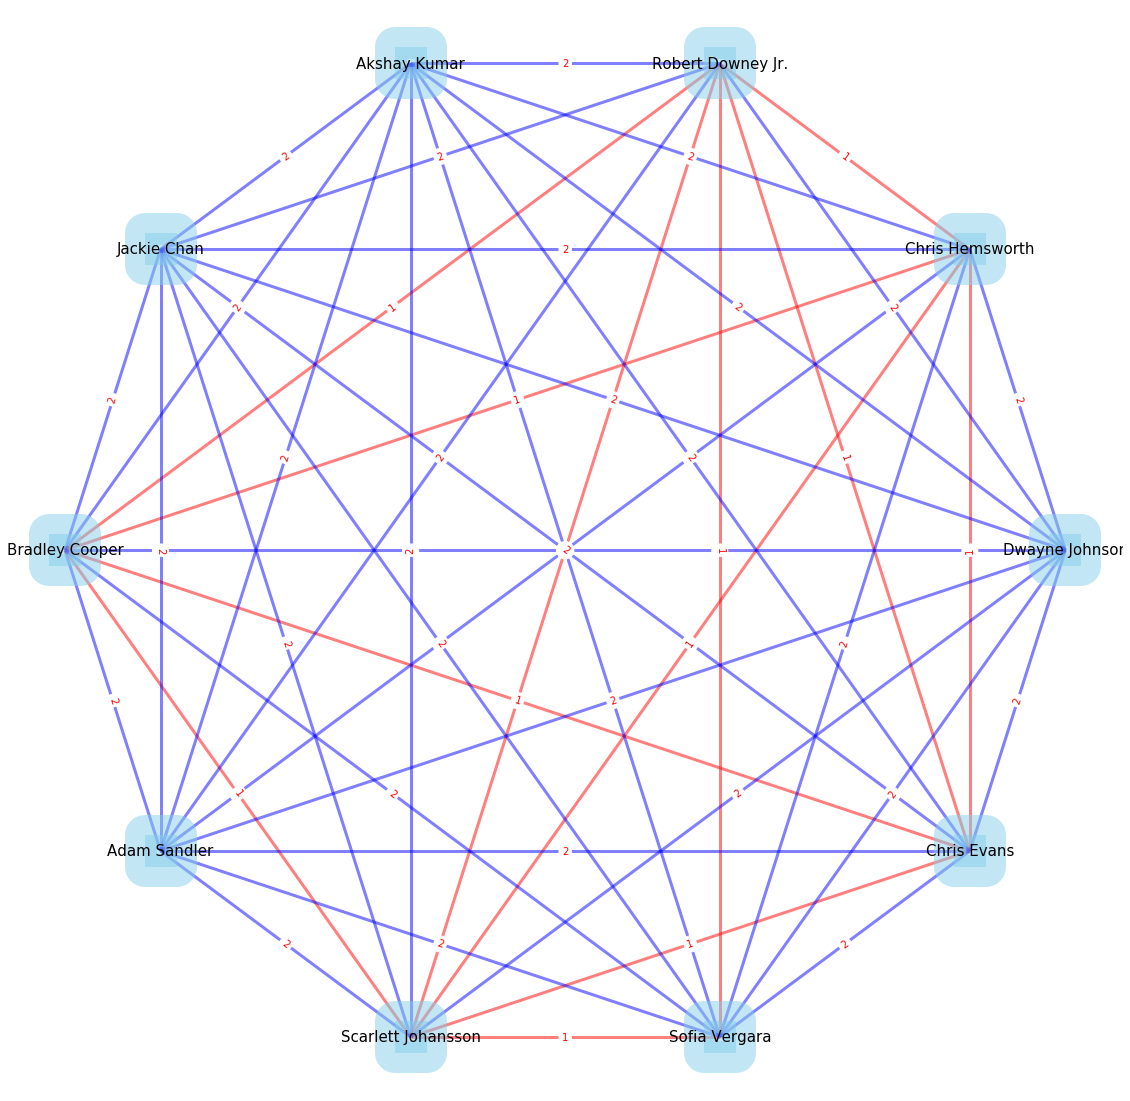

In [226]:
plt.figure(figsize=(20,20)) 
pos = nx.circular_layout(G)
dist1 = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] == 1]
dist2 = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] == 2]
nx.draw_networkx_nodes(G, pos, with_labels=True, node_size=1000, node_color="skyblue", node_shape="s", alpha=0.5, linewidths=40)

nx.draw_networkx_edges(G, pos, edgelist=dist1, width=3, alpha=0.5, edge_color="r", label='1')
nx.draw_networkx_edges(G, pos, edgelist=dist2, width=3, alpha=0.5, edge_color="b", label='2')
nx.draw_networkx_labels(G, pos, font_size=15)

edge_labels = nx.get_edge_attributes(G,'weight') 
formatted_edge_labels = {(elem[0],elem[1]):edge_labels[elem] for elem in edge_labels} 
nx.draw_networkx_edge_labels(G,pos,edge_labels=formatted_edge_labels,font_color='red')

plt.axis("off")
plt.savefig('top10_viz.png')
plt.show()                        


### Only with distance 1

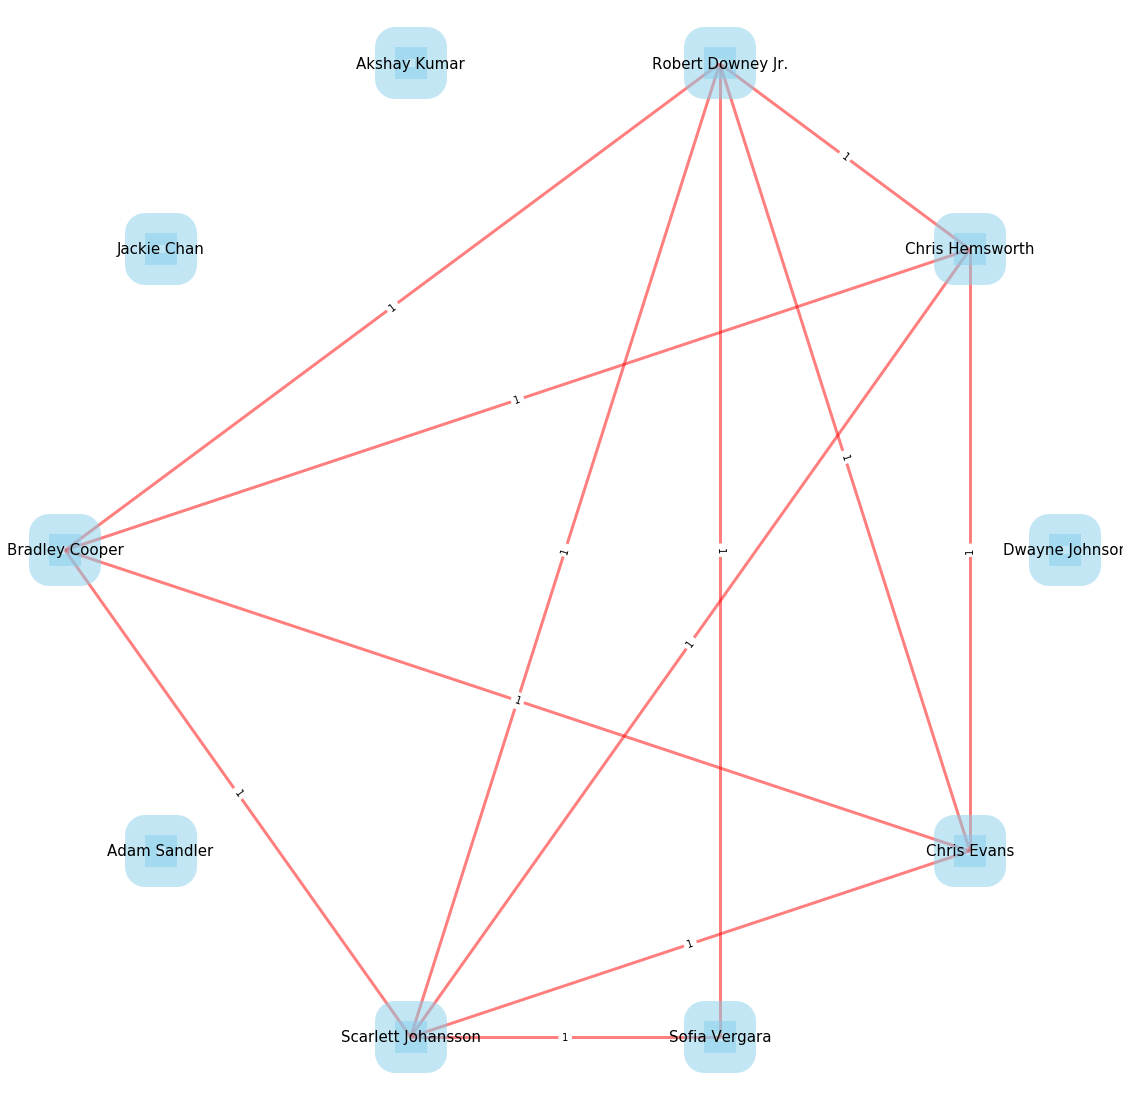

In [261]:
plt.figure(figsize=(20,20)) 
pos = nx.circular_layout(G)
dist1 = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] == 1]
# dist2 = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] == 2]
nx.draw_networkx_nodes(G, pos, with_labels=True, node_size=1000, node_color="skyblue", node_shape="s", alpha=0.5, linewidths=40)

nx.draw_networkx_edges(G, pos, edgelist=dist1, width=3, alpha=0.5, edge_color="r", label='1')
# nx.draw_networkx_edges(G, pos, edgelist=dist2, width=3, alpha=0.5, edge_color="b", label='2')
nx.draw_networkx_labels(G, pos, font_size=15)

edge_labels = nx.get_edge_attributes(G,'weight') 
formatted_edge_labels = {(elem[0],elem[1]):edge_labels[elem] for elem in edge_labels if edge_labels[elem] == 1}
nx.draw_networkx_edge_labels(G,pos,edge_labels=formatted_edge_labels,font_color='black')

plt.axis("off")
plt.savefig('top10_viz_dist1.png')
plt.show()                        


### Only with distance 2

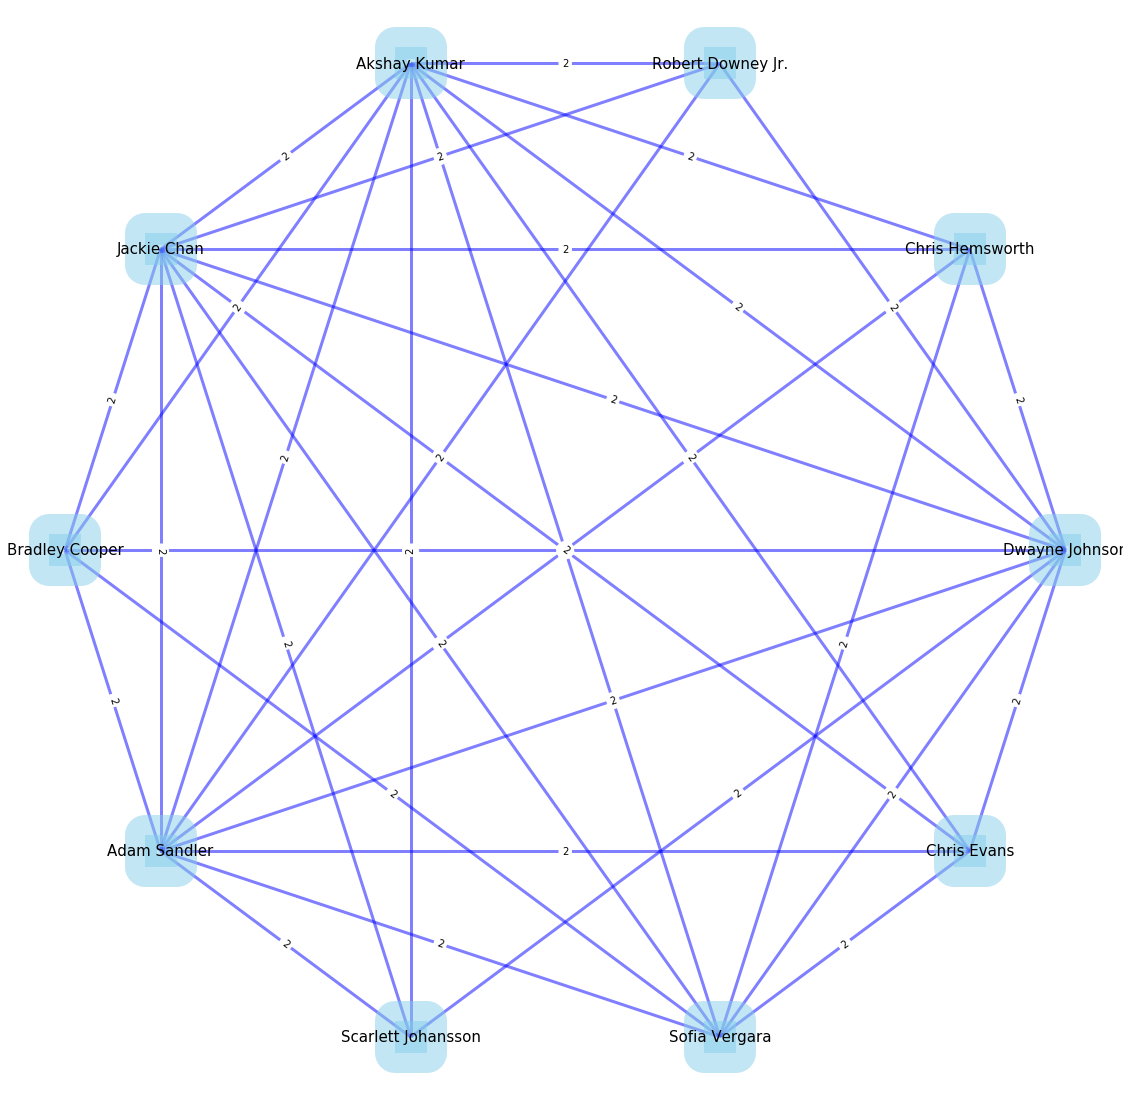

In [262]:
plt.figure(figsize=(20,20)) 
pos = nx.circular_layout(G)
# dist1 = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] == 1]
dist2 = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] == 2]
nx.draw_networkx_nodes(G, pos, with_labels=True, node_size=1000, node_color="skyblue", node_shape="s", alpha=0.5, linewidths=40)

# nx.draw_networkx_edges(G, pos, edgelist=dist1, width=3, alpha=0.5, edge_color="r", label='1')
nx.draw_networkx_edges(G, pos, edgelist=dist2, width=3, alpha=0.5, edge_color="b", label='2')
nx.draw_networkx_labels(G, pos, font_size=15)

edge_labels = nx.get_edge_attributes(G,'weight') 
formatted_edge_labels = {(elem[0],elem[1]):edge_labels[elem] for elem in edge_labels if edge_labels[elem] == 2}
nx.draw_networkx_edge_labels(G,pos,edge_labels=formatted_edge_labels,font_color='black')

plt.axis("off")
plt.savefig('top10_viz_dist2.png')
plt.show()    

## Wordcloud

### Gatherind data

In [20]:
descriptions = {}
for key, value in top10.items():
    fname = key.lower().replace(' ','_').replace('.','') + '.csv'
    soup = await word_soup(value)
    descr = await get_movie_descriptions_by_actor_soup(soup, 10)
    descriptions[key] = descr
    with open(fname, 'w+') as f:
        f.write(descr)

In [46]:
with open('descriptions.data', 'wb') as file:
    # store the data as binary data stream
    pickle.dump(descriptions, file)

### Using templates to get worldclouds

#### Stopwords

In [36]:
stopwords = set(STOPWORDS)
stopwords.update(["summary\xa0»", "...\n", "full", "summary", "see"])

#### Dwayne Johnson

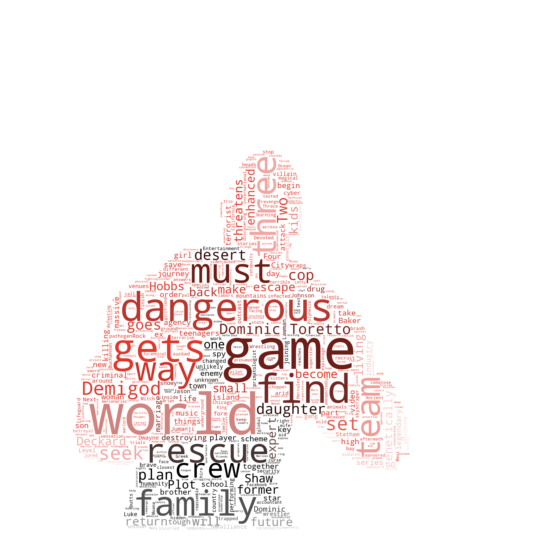

In [29]:
# Generate a word cloud image
text = descriptions['Dwayne Johnson']
mask = np.array(Image.open("templates/Dwayne-Rock-Johnsson.jpg"))
wordcloud = WordCloud(stopwords=stopwords, background_color="white", 
                      mode="RGBA", max_words=1000, mask=mask).generate(text)

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[10,10])

plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.savefig('dwayne_johnson_worldcloud.png')


#### Chris Hemsworth

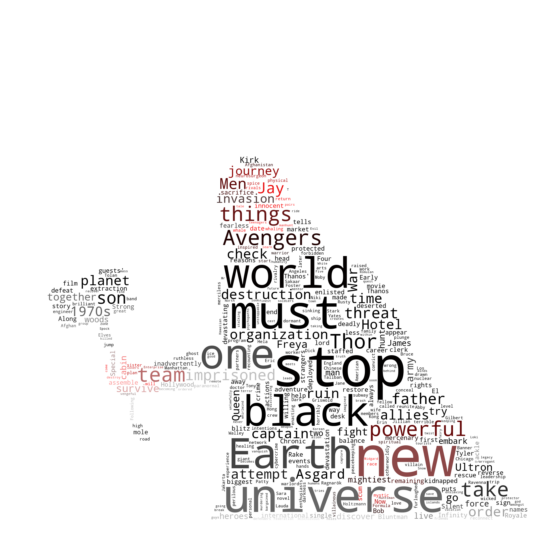

In [31]:
# Generate a word cloud image
text = descriptions['Chris Hemsworth']
mask = np.array(Image.open("templates/Thor.jpg"))
wordcloud = WordCloud(stopwords=stopwords, background_color="white", 
                      mode="RGBA", max_words=1000, mask=mask).generate(text)

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[10,10])

plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.savefig('chris_hemsworth_worldcloud.png')


#### Robert Downey Jr.

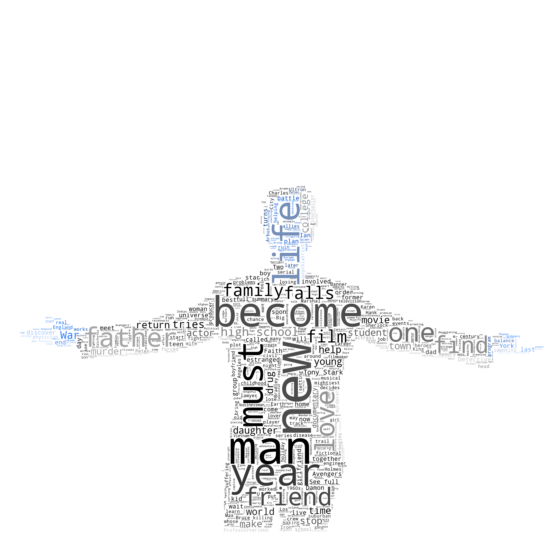

In [32]:
# Generate a word cloud image
text = descriptions['Robert Downey Jr.']
mask = np.array(Image.open("templates/ironman.jpg"))
wordcloud = WordCloud(stopwords=stopwords, background_color="white", 
                      mode="RGBA", max_words=1000, mask=mask).generate(text)

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[10,10])

plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.savefig('robert_downey_jr_worldcloud.png')


#### Akshay Kumar

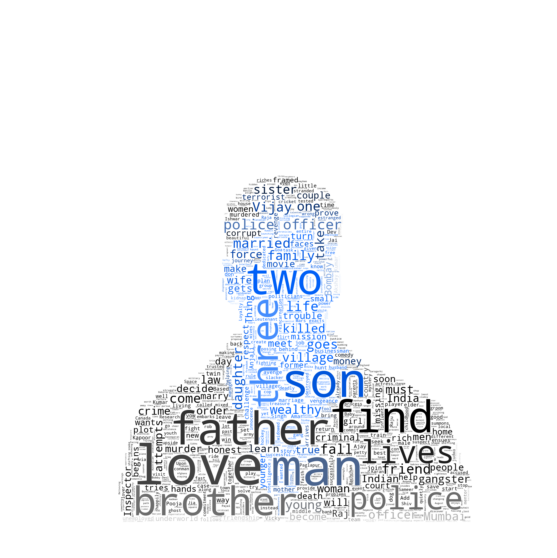

In [37]:
# Generate a word cloud image
text = descriptions['Akshay Kumar']
mask = np.array(Image.open("templates/akshay-kumar.jpg"))
wordcloud = WordCloud(stopwords=stopwords, background_color="white", 
                      mode="RGBA", max_words=1000, mask=mask).generate(text)

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[10,10])

plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.savefig('akshay_kumar_worldcloud.png')


#### Jackie Chan

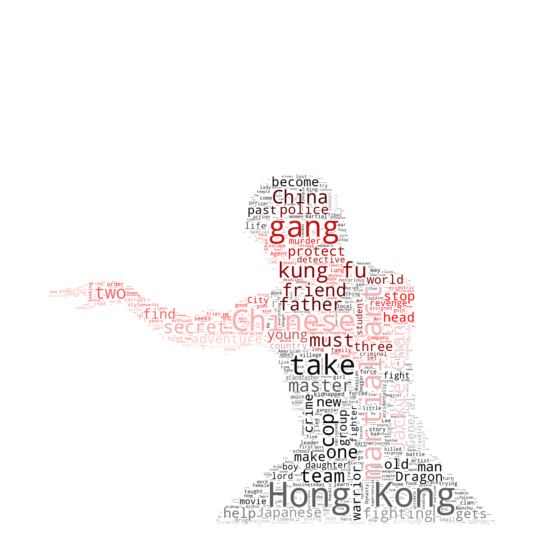

In [38]:
# Generate a word cloud image
text = descriptions['Jackie Chan']
mask = np.array(Image.open("templates/Jackie-chan.jpg"))
wordcloud = WordCloud(stopwords=stopwords, background_color="white", 
                      mode="RGBA", max_words=1000, mask=mask).generate(text)

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[10,10])

plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.savefig('jackie_chan_worldcloud.png')


#### Bradley Cooper

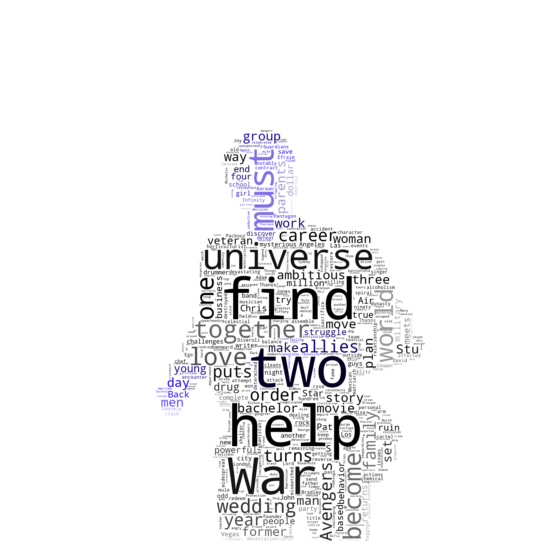

In [39]:
# Generate a word cloud image
text = descriptions['Bradley Cooper']
mask = np.array(Image.open("templates/Bradley-Cooper.jpg"))
wordcloud = WordCloud(stopwords=stopwords, background_color="white", 
                      mode="RGBA", max_words=1000, mask=mask).generate(text)

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[10,10])

plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.savefig('bradley_cooper_worldcloud.png')


#### Adam Sandler

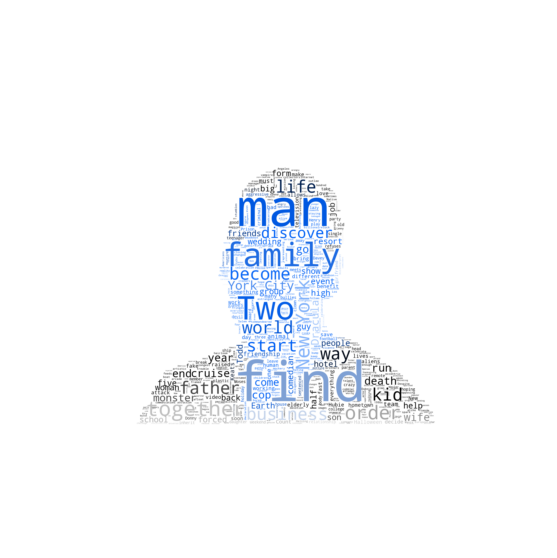

In [40]:
# Generate a word cloud image
text = descriptions['Adam Sandler']
mask = np.array(Image.open("templates/Adam-Sandler.jpg"))
wordcloud = WordCloud(stopwords=stopwords, background_color="white", 
                      mode="RGBA", max_words=1000, mask=mask).generate(text)

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[10,10])

plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.savefig('adam_sandler_worldcloud.png')


#### Scarlett Johansson

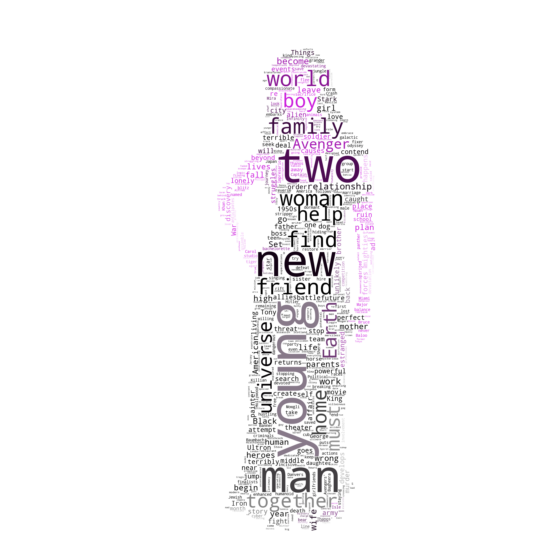

In [41]:
# Generate a word cloud image
text = descriptions['Scarlett Johansson']
mask = np.array(Image.open("templates/Scarlet.jpg"))
wordcloud = WordCloud(stopwords=stopwords, background_color="white", 
                      mode="RGBA", max_words=1000, mask=mask).generate(text)

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[10,10])

plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.savefig('scarlett_johansson_worldcloud.png')


#### Sofia Vergara

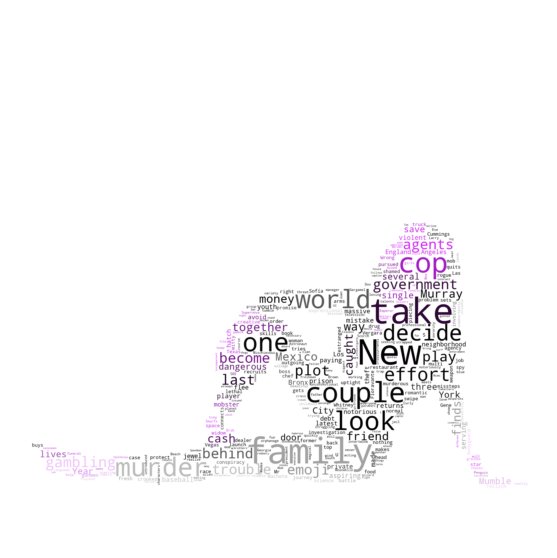

In [44]:
# Generate a word cloud image
text = descriptions['Sofia Vergara']
mask = np.array(Image.open("templates/Sophia-Vergara.jpg"))
wordcloud = WordCloud(stopwords=stopwords, background_color="white", 
                      mode="RGBA", max_words=1000, mask=mask).generate(text)

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[10,10])

plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.savefig('sofia_vergara_worldcloud.png')


#### Chris Evans

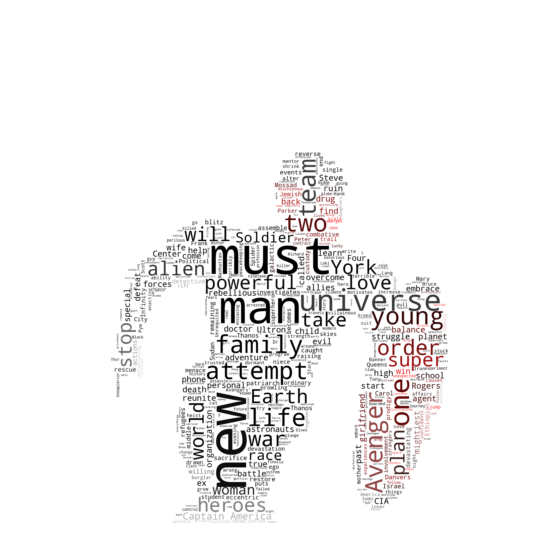

In [45]:
# Generate a word cloud image
text = descriptions['Chris Evans']
mask = np.array(Image.open("templates/Chris-Evans.jpg"))
wordcloud = WordCloud(stopwords=stopwords, background_color="white", 
                      mode="RGBA", max_words=1000, mask=mask).generate(text)

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[10,10])

plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.savefig('chris_evans_worldcloud.png')


## That's all, folks!

Thank you for the fun project and course! I enjoyed most of it and, especially, the final project.